In [42]:
import os
import numpy
import pandas
import pandasql
from matplotlib import pyplot
from scipy import stats

In [2]:
d = './data/'
listed = {}
columns = ['time', 'action', 'order_id', 'size', 'price', 'direction']
for file in os.listdir(d):
    if '.csv' in file:
        g = '{0}{1}'.format(d, file)
        data = pandas.read_csv(g, header=None, names=columns)
        name = file[:file.index('.csv')]
        listed[name] = data

In [22]:
data = listed['AMZN_message_1']
data

,time,action,order_id,size,price,direction
0,34200.017460,5,0,1,2238200,-1
1,34200.189608,1,11885113,21,2238100,1
2,34200.190226,4,11885113,21,2238100,1
3,34200.190226,4,11534792,26,2237500,1
4,34200.372780,5,0,100,2238400,-1
...,...,...,...,...,...,...
57510,57599.545828,4,282917222,9,2205100,1
57511,57599.545828,4,286916542,51,2205100,1
57512,57599.903989,3,287142900,100,2206200,-1
57513,57599.958245,1,287174077,100,2206300,-1


In [23]:
data['action']

0        5
1        1
2        4
3        4
4        5
        ..
57510    4
57511    4
57512    3
57513    1
57514    3
Name: action, Length: 57515, dtype: int64

In [24]:
def merge(dataset):
    query = """
    select a.time as time_left
         , a.action as action_left
         , a.order_id as order_id_left
         , a.size as size_left
         , a.price as price_left
         , a.direction as direction_left
         , b.time as time_right
         , b.action as action_right
         , b.order_id as order_id_right
         , b.size as size_right
         , b.price as price_right
         , b.direction as direction_right
    from 
    (
    select *
    from dataset
    where action = {0}
    ) as a
    full outer join
    (
    select *
    from dataset
    where action = {1}
    ) as b
    on a.order_id = b.order_id
    and a.time < b.time
    """.format(1, 4)
    merged = pandasql.sqldf(query, locals())
    return merged

In [6]:
(merged['order_id_left'].value_counts() > 1).sum()

NameError: name 'merged' is not defined

In [ ]:
merged['order_id_left'].value_counts()

In [ ]:
merged[merged['order_id_left'] == 229024957]

In [ ]:
# ACTION

In [25]:
def make_pp(frame, target):
    frame = frame.sort_values(by=target, ascending=True)
    frame['n'] = 1
    frame['nn'] = frame['n'].cumsum() / frame['n'].sum()
    frame = frame.drop(columns=['n'])
    return frame

def calc_exp(x, scale):
    return numpy.log(1 - x) / scale

In [26]:
data['time'].diff().iloc[1:].sort_values()

19434     0.000000
29849     0.000000
27252     0.000000
27251     0.000000
27250     0.000000
           ...    
32175    26.415379
39960    26.734110
33989    35.069842
44582    38.100072
37340    38.286680
Name: time, Length: 57514, dtype: float64

<Axes: >

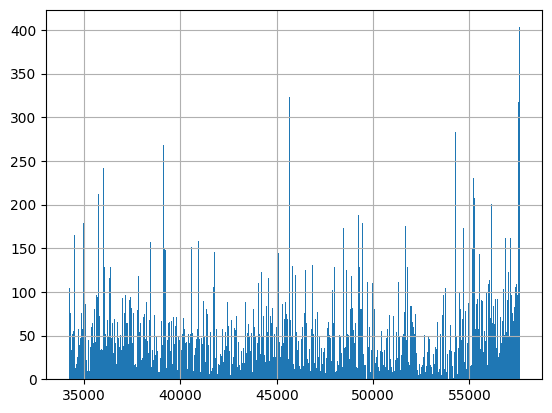

In [27]:
data['time'].hist(bins=1000)

In [79]:
def get_at_selection(action_net, time_thresh_set, ex_time, ignore_zeros=True):
    
    ex_data = data.copy()
    if ex is not None:
        ex_data = ex_data[~numpy.isin(ex_data['time'].values, ex_time)]
        
    # all actions whole time
    
    sub_data = ex_data.copy()
    time_diffs = sub_data[['time']].diff().iloc[1:]
    if ignore_zeros:
        time_diffs = time_diffs[time_diffs['time'] > 0]
    time_diffs = make_pp(time_diffs, 'time')
    scale = 1
    time_diffs['gg'] = time_diffs['nn'].apply(func=calc_exp, args=(scale,))
    
    result_all_actions_whole_time = {'xx': time_diffs['time'].values, 'yy': time_diffs['gg'].values}
    
    # specific actions whole time
    
    result_spec_actions_whole_time = {}
    for action in action_net:
        sub_data = ex_data.copy()
        
        sub_data = sub_data[sub_data['action'] == action]
        
        time_diffs = sub_data[['time']].diff().iloc[1:]
        if ignore_zeros:
            time_diffs = time_diffs[time_diffs['time'] > 0]
        time_diffs = make_pp(time_diffs, 'time')
        scale = 1
        time_diffs['gg'] = time_diffs['nn'].apply(func=calc_exp, args=(scale,))

        result_spec_actions_whole_time[action] = {'xx': time_diffs['time'].values, 'yy': time_diffs['gg'].values}

    # all actions specific time
    
    result_all_actions_specific_time = {}
    for j in range(len(time_thresh_set) - 1):
        sub_data = ex_data.copy()
        
        sub_data = sub_data[(sub_data['time'] >= time_thresh_set[j]) & (sub_data['time'] < time_thresh_set[j+1])]
        
        time_diffs = sub_data[['time']].diff().iloc[1:]
        if ignore_zeros:
            time_diffs = time_diffs[time_diffs['time'] > 0]
        time_diffs = make_pp(time_diffs, 'time')
        scale = 1
        time_diffs['gg'] = time_diffs['nn'].apply(func=calc_exp, args=(scale,))

        result_all_actions_specific_time[j] = {'xx': time_diffs['time'].values, 'yy': time_diffs['gg'].values}
    
    # speicific actions specific time
    
    result_specall = {}
    for action in action_net:
        sub_data = ex_data.copy()
        
        sub_data = sub_data[data['action'] == action]
        
        result_specall[action] = {}
        for j in range(len(time_thresh_set) - 1):
            subspec_data = sub_data.copy()
            
            subspec_data = subspec_data[(subspec_data['time'] >= time_thresh_set[j]) & (subspec_data['time'] < time_thresh_set[j+1])]
        
            time_diffs = subspec_data[['time']].diff().iloc[1:]
            if ignore_zeros:
                time_diffs = time_diffs[time_diffs['time'] > 0]
            time_diffs = make_pp(time_diffs, 'time')
            scale = 1
            time_diffs['gg'] = time_diffs['nn'].apply(func=calc_exp, args=(scale,))

            result_specall[action][j] = {'xx': time_diffs['time'].values, 'yy': time_diffs['gg'].values}
        
    return result_all_actions_whole_time, result_spec_actions_whole_time, result_all_actions_specific_time, result_specall

In [80]:
action_net = [1, 2, 3, 4, 5]
ex = []
time_thresh_set = [-numpy.inf, 45900, 51750, numpy.inf]
xaya, xsya, xays, xsyx = get_at_selection(action_net, time_thresh_set, ex)


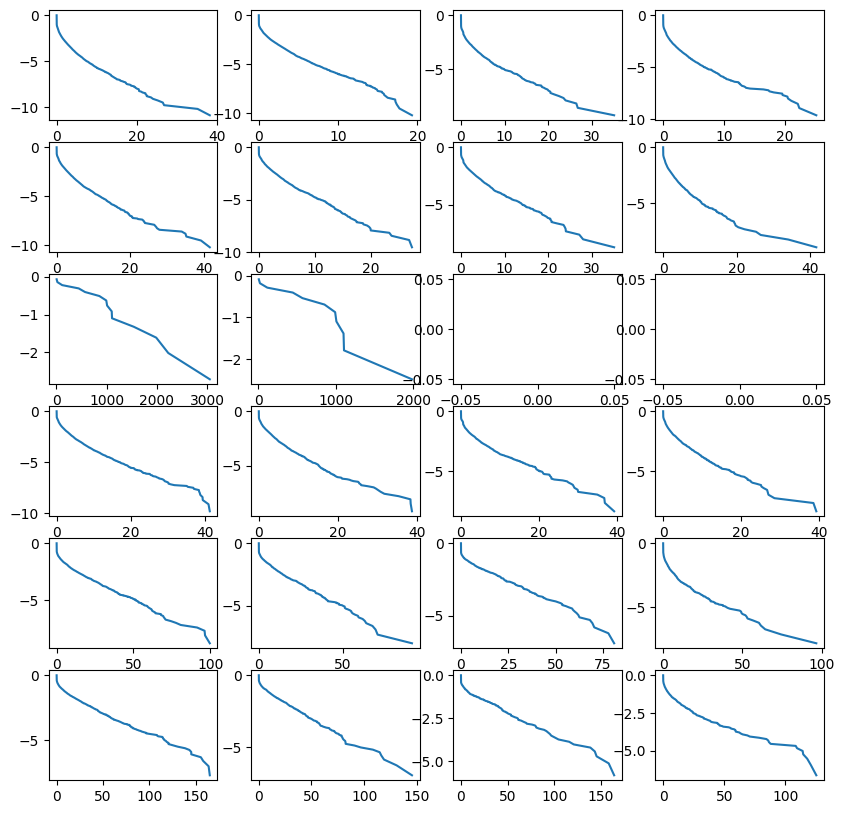

In [81]:
fig, ax = pyplot.subplots(len(action_net)+1, len(time_thresh_set), figsize=(10, 10))
ax[0, 0].plot(xaya['xx'], xaya['yy'])
for i in range(len(action_net)):
    sx = xsya[action_net[i]]
    ax[i+1, 0].plot(sx['xx'], sx['yy'])
for j in range(len(time_thresh_set)-1):
    sy = xays[j]
    ax[0, j+1].plot(sy['xx'], sy['yy'])
for i in range(len(action_net)):
    for j in range(len(time_thresh_set)-1):
        sa = xsyx[action_net[i]][j]
        ax[i+1, j+1].plot(sa['xx'], sa['yy'])

In [82]:
data[['size']].describe()

,size
count,57515.000000
mean,89.517274
std,297.909696
min,1.000000
25%,16.000000
50%,100.000000
75%,100.000000
max,33570.000000


In [83]:
def get_as_selection(action_net, size_thresh_set, ex_time):
    
    ex_data = data.copy()
    if ex is not None:
        ex_data = ex_data[~numpy.isin(ex_data['time'].values, ex_time)]
        
    # all actions all sizes
    
    sub_data = ex_data.copy()
    time_diffs = sub_data[['time']].diff().iloc[1:]
    time_diffs = make_pp(time_diffs, 'time')
    scale = 1
    time_diffs['gg'] = time_diffs['nn'].apply(func=calc_exp, args=(scale,))
    tt = list(range(time_diffs.shape[0]))

    items_dist = numpy.array(range(sub_data.shape[0])) / sub_data.shape[0]
    size_dist = sub_data['size'].cumsum() / sub_data['size'].sum()
    xx = list(range(sub_data.shape[0]))
    time_ax = (sub_data['time'] - sub_data['time'].min()) / (sub_data['time'] - sub_data['time'].min()).max()
    
    result_all_actions_all_sizes = {'xx': time_diffs['time'].values, 'yy': time_diffs['gg'].values}
    
    # specific actions all sizes
    
    result_spec_actions_all_sizes = {}
    for action in action_net:
        sub_data = ex_data.copy()
        
        sub_data = sub_data[sub_data['action'] == action]
        
        time_diffs = sub_data[['time']].diff().iloc[1:]
        time_diffs = make_pp(time_diffs, 'time')
        scale = 1
        time_diffs['gg'] = time_diffs['nn'].apply(func=calc_exp, args=(scale,))
        tt = list(range(time_diffs.shape[0]))

        items_dist = numpy.array(range(sub_data.shape[0])) / sub_data.shape[0]
        size_dist = sub_data['size'].cumsum() / sub_data['size'].sum()
        xx = list(range(sub_data.shape[0]))
        time_ax = (sub_data['time'] - sub_data['time'].min()) / (sub_data['time'] - sub_data['time'].min()).max()

        result_spec_actions_all_sizes[action] = {'xx': time_diffs['time'].values, 'yy': time_diffs['gg'].values}

    # all actions specific size
    
    result_all_actions_specific_size = {}
    for j in range(len(size_thresh_set) - 1):
        sub_data = ex_data.copy()
        
        sub_data = sub_data[(sub_data['size'] >= size_thresh_set[j]) & (sub_data['size'] < size_thresh_set[j+1])]
        
        time_diffs = sub_data[['time']].diff().iloc[1:]
        time_diffs = make_pp(time_diffs, 'time')
        scale = 1
        time_diffs['gg'] = time_diffs['nn'].apply(func=calc_exp, args=(scale,))
        tt = list(range(time_diffs.shape[0]))

        items_dist = numpy.array(range(sub_data.shape[0])) / sub_data.shape[0]
        size_dist = sub_data['size'].cumsum() / sub_data['size'].sum()
        xx = list(range(sub_data.shape[0]))
        time_ax = (sub_data['time'] - sub_data['time'].min()) / (sub_data['time'] - sub_data['time'].min()).max()

        result_all_actions_specific_size[j] = {'xx': time_diffs['time'].values, 'yy': time_diffs['gg'].values}
    
    # speicific actions specific size
    
    result_specall = {}
    for action in action_net:
        sub_data = ex_data.copy()
        
        sub_data = sub_data[data['action'] == action]
        
        result_specall[action] = {}
        for j in range(len(size_thresh_set) - 1):
            subspec_data = sub_data.copy()
            
            subspec_data = subspec_data[(subspec_data['size'] >= size_thresh_set[j]) & (subspec_data['size'] < size_thresh_set[j+1])]
        
            time_diffs = subspec_data[['time']].diff().iloc[1:]
            time_diffs = make_pp(time_diffs, 'time')
            scale = 1
            time_diffs['gg'] = time_diffs['nn'].apply(func=calc_exp, args=(scale,))
            tt = list(range(time_diffs.shape[0]))

            items_dist = numpy.array(range(subspec_data.shape[0])) / subspec_data.shape[0]
            size_dist = subspec_data['size'].cumsum() / subspec_data['size'].sum()
            xx = list(range(subspec_data.shape[0]))
            time_ax = (subspec_data['time'] - subspec_data['time'].min()) / (subspec_data['time'] - subspec_data['time'].min()).max()

            result_specall[action][j] = {'xx': time_diffs['time'].values, 'yy': time_diffs['gg'].values}
        
    return result_all_actions_all_sizes, result_spec_actions_all_sizes, result_all_actions_specific_size, result_specall

In [84]:
action_net = [1, 2, 3, 4, 5]
ex = []
size_thresh_set = [-numpy.inf, 10, 100, numpy.inf]
xaya, xsya, xays, xsyx = get_as_selection(action_net, size_thresh_set, ex)


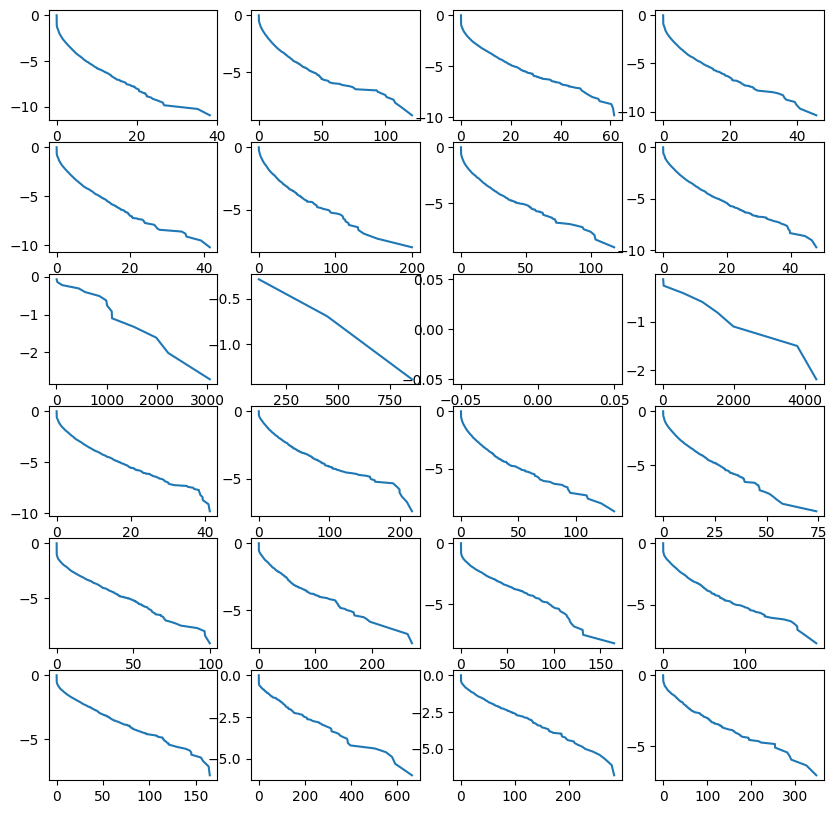

In [85]:
fig, ax = pyplot.subplots(len(action_net)+1, len(size_thresh_set), figsize=(10, 10))
ax[0, 0].plot(xaya['xx'], xaya['yy'])
for i in range(len(action_net)):
    sx = xsya[action_net[i]]
    ax[i+1, 0].plot(sx['xx'], sx['yy'])
for j in range(len(size_thresh_set)-1):
    sy = xays[j]
    ax[0, j+1].plot(sy['xx'], sy['yy'])
for i in range(len(action_net)):
    for j in range(len(size_thresh_set)-1):
        sa = xsyx[action_net[i]][j]
        ax[i+1, j+1].plot(sa['xx'], sa['yy'])

In [67]:
def build_diffs(frame, drop_zeros=False):
    time_diffs = frame[['time']].diff().iloc[1:]
    if drop_zeros:
        time_diffs = time_diffs[time_diffs['time'] > 0]
    time_diffs = make_pp(time_diffs, 'time')
    scale = 1
    time_diffs['gg'] = time_diffs['nn'].apply(func=calc_exp, args=(scale,))

    return {'xx': time_diffs['time'].values, 'yy': time_diffs['gg'].values}

In [68]:
# selection = data[(data['action'] == 1) & (data['size'] < 10)]
selection = data[(data['action'] == 4)]

diffs = build_diffs(frame=selection)

In [43]:
scale = 1
test = pandas.DataFrame(data={'xx': numpy.random.exponential(scale=scale, size=(10000,))})
test = make_pp(test, 'xx')
test['yy'] = test['nn'].apply(func=calc_exp, args=(scale,))

pyplot.plot(test['xx'].values, test['yy'].values, 'blue', diffs['xx'], diffs['yy'], 'orange')

NameError: name 'diffs' is not defined

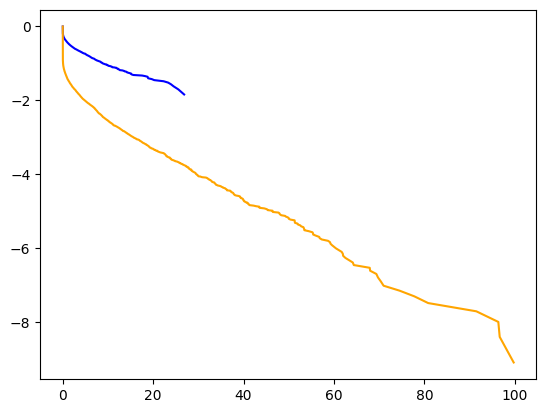

In [90]:
a = 0.1
scale = 5
test = pandas.DataFrame(data={'xx': stats.gamma.rvs(a=a, scale=scale, size=(10000,))})
test = make_pp(test, 'xx')
test['yy'] = test['nn'].apply(func=calc_exp, args=(scale,))

pyplot.plot(test['xx'].values, test['yy'].values, 'blue', diffs['xx'], diffs['yy'], 'orange')

In [66]:
a = 0.1
c = 1.4
scale = 1
test = pandas.DataFrame(data={'xx': stats.gengamma.rvs(a=a, c=c, scale=scale, size=(10000,))})
test = make_pp(test, 'xx')
test['yy'] = test['nn'].apply(func=calc_exp, args=(scale,))

pyplot.plot(test['xx'].values, test['yy'].values, 'blue', diffs['xx'], diffs['yy'], 'orange')
# pyplot.plot(test['xx'].values, test['yy'].values, 'blue')

NameError: name 'diffs' is not defined

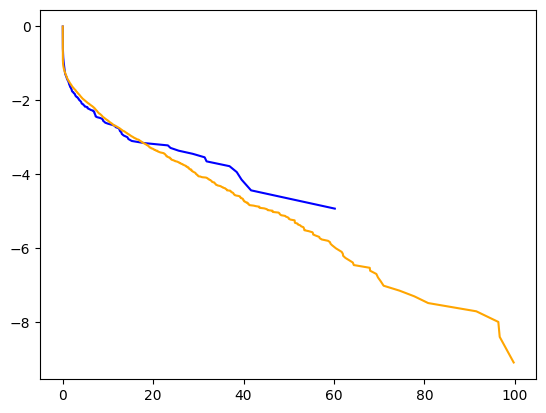

In [78]:
a = 0.4
c = 0.4
scale = 1.4
test = pandas.DataFrame(data={'xx': stats.gengamma.rvs(a=a, c=c, scale=scale, size=(1000,))})
test = make_pp(test, 'xx')
test['yy'] = test['nn'].apply(func=calc_exp, args=(scale,))

pyplot.plot(test['xx'].values, test['yy'].values, 'blue', diffs['xx'], diffs['yy'], 'orange')

In [486]:
stats.gengamma.fit(diffs['xx'], 0.4, 0.3, loc=0, scale=1)

(0.4008780629689852,
 0.3200821845067058,
 -1.6289675777559528e-34,
 0.9643334820014512)

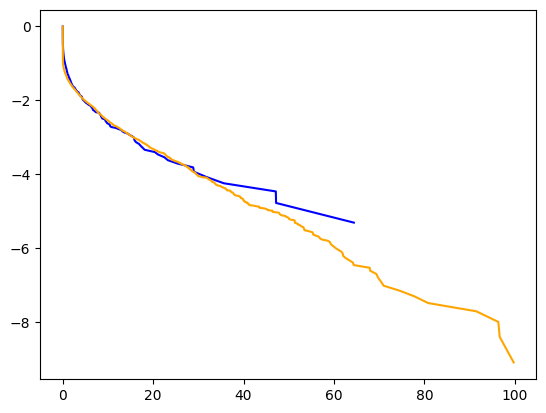

In [506]:
a = 0.55
c = 0.4
scale = 1.3
test = pandas.DataFrame(data={'xx': stats.gengamma.rvs(a=a, c=c, scale=scale, size=(1000,))})
test = make_pp(test, 'xx')
test['yy'] = test['nn'].apply(func=calc_exp, args=(scale,))

pyplot.plot(test['xx'].values, test['yy'].values, 'blue', diffs['xx'], diffs['yy'], 'orange')

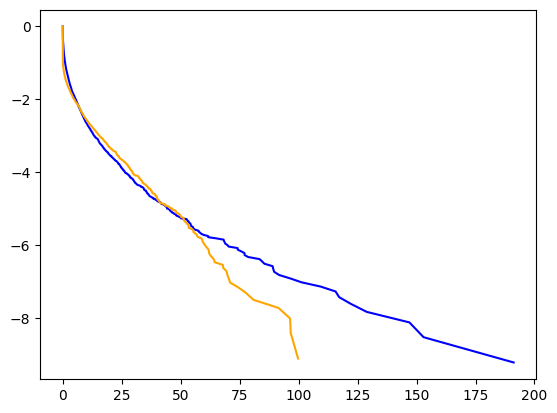

In [433]:
a = 0.42
scale = 1
test = pandas.DataFrame(data={'xx': scale * numpy.random.weibull(a=a, size=(10000,))})
test = make_pp(test, 'xx')
test['yy'] = test['nn'].apply(func=calc_exp, args=(scale,))

pyplot.plot(test['xx'].values, test['yy'].values, 'blue', diffs['xx'], diffs['yy'], 'orange')

In [76]:
def get_dist(action,):

    ex_time = [34200.18960767, 34200.779744711]
    sub_data = data[(data['action'] == action) & ~numpy.isin(data['time'].values, ex_time)]
    time_diffs = sub_data[['time']].diff().iloc[1:]
    time_diffs = make_pp(time_diffs, 'time')
    scale = 1
    time_diffs['gg'] = time_diffs['nn'].apply(func=calc_exp, args=(scale,))
    tt = list(range(time_diffs.shape[0]))

    items_dist = numpy.array(range(sub_data.shape[0])) / sub_data.shape[0]
    size_dist = sub_data['size'].cumsum() / sub_data['size'].sum()
    xx = list(range(sub_data.shape[0]))
    time_ax = (sub_data['time'] - sub_data['time'].min()) / (sub_data['time'] - sub_data['time'].min()).max()
    
    return {'xx': time_diffs['time'].values, 'yy': time_diffs['gg'].values}



In [21]:
data[['size']].describe()

,size
count,269748.000000
mean,96.870505
std,168.846801
min,1.000000
25%,21.000000
50%,100.000000
75%,100.000000
max,33570.000000


In [77]:
def plot_vs_exp(sel, scale, n=None):
    if n is None:
        n = sel['xx'].shape[0]
    test = pandas.DataFrame(data={'xx': numpy.random.exponential(scale=scale, size=(n,))})
    test = make_pp(test, 'xx')
    test['yy'] = test['nn'].apply(func=calc_exp, args=(scale,))
    
    pyplot.plot(test['xx'].values, test['yy'].values, 'blue', sub_data['xx'], sub_data['yy'], 'orange')

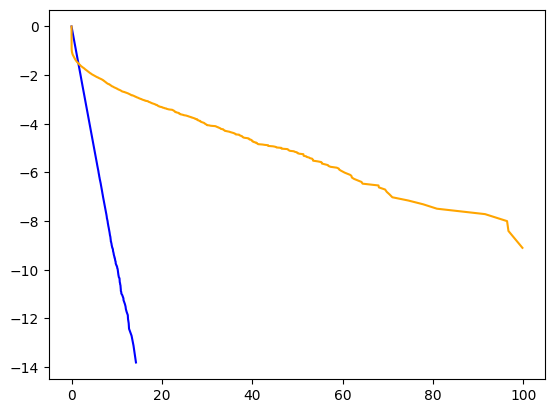

In [151]:
selected = get_dist(action=4)
plot_vs_exp(selected, scale=1, n=1000000)

In [29]:
sub_data = data.copy()
time_diffs = sub_data[['time']].diff().iloc[1:]
time_diffs = make_pp(time_diffs, 'time')
scale = 1
time_diffs['gg'] = time_diffs['nn'].apply(func=calc_exp, args=(scale,))
tt = list(range(time_diffs.shape[0]))

items_dist = numpy.array(range(sub_data.shape[0])) / sub_data.shape[0]
size_dist = sub_data['size'].cumsum() / sub_data['size'].sum()
xx = list(range(sub_data.shape[0]))
min_time = sub_data['time'].min()
max_cond_time = (sub_data['time'] - min_time).max()
time_ax = (sub_data['time'] - min_time) / max_cond_time

result_all_actions_whole_time = {'xx': time_diffs['time'].values, 'yy': time_diffs['gg'].values}

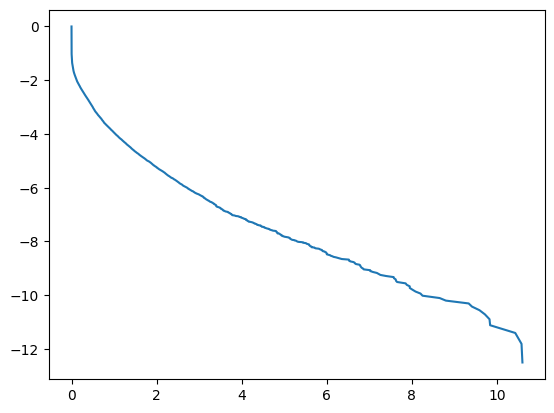

In [20]:
pyplot.plot(time_diffs['time'].values, time_diffs['gg'].values)

In [31]:
value = 0.85
value * max_cond_time + min_time

54089.96807464505

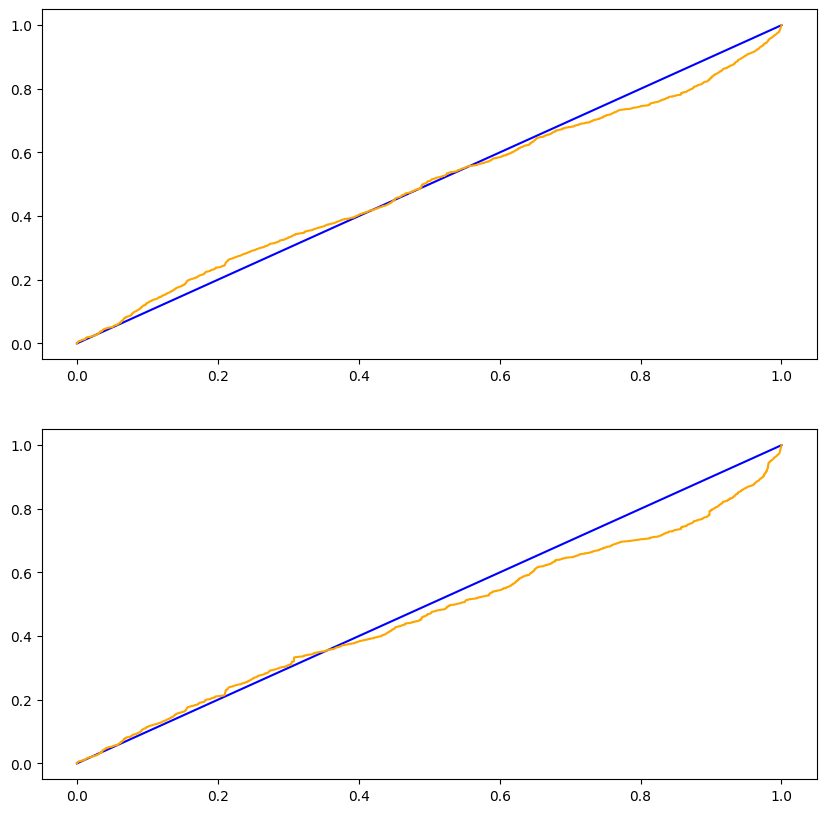

In [30]:
fig, ax = pyplot.subplots(2, 1, figsize=(10, 10))
ax[0].plot(time_ax, time_ax, 'blue', time_ax, items_dist, 'orange')
ax[1].plot(time_ax, time_ax, 'blue', time_ax, size_dist, 'orange')

In [ ]:
fig, ax = pyplot.subplots(2, 1, figsize=(10, 10))
ax[0].plot(time_ax, time_ax, 'blue', time_ax, items_dist, 'orange')
ax[1].plot(time_ax, time_ax, 'blue', time_ax, size_dist, 'orange')

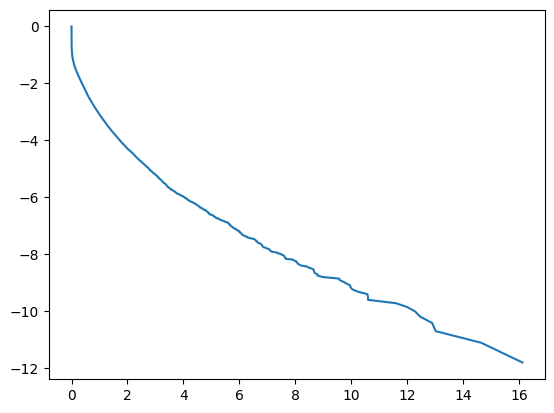

In [40]:
pyplot.plot(time_diffs['time'].values, time_diffs['gg'].values)

In [27]:
sub_data['time'].value_counts().index

Index([ 34200.18960767, 34200.779744711, 50841.095143086, 50842.055541986,
       50842.054813486,  50842.05361109, 50842.052677122, 50842.052632644,
       50842.052164663, 50842.051678929,
       ...
       41195.906823368, 41195.906727651, 41195.906631989, 41195.900286189,
       41195.900144686, 41195.899675747, 41195.899640149,  41195.89948106,
       41195.754757189, 57599.958244616],
      dtype='float64', name='time', length=131919)

In [3]:
# DIRECTION

In [4]:
# TIME

In [5]:
# COMBINED

In [ ]:
# SIZE